walmart 주단위 데이터 139주로 향후 4주 예측하기

In [311]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime  
tf.set_random_seed(77)
columns=['date','sales']
txs=pd.read_table('./lstmData/lstmPrac11.csv', sep=',',header=None,names=columns )
tf.reset_default_graph()

In [312]:
txs

,date,sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
5,2010-03-12,21043.39
6,2010-03-19,22136.64
7,2010-03-26,26229.21
8,2010-04-02,57258.43
9,2010-04-09,42960.91


In [313]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)
def sqrtSales(sales):
    return np.sqrt(sales)


def rmse(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt(sum/len(a))

def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier


In [314]:
def LSTM(txs, forecastDay, features):
    tf.set_random_seed(77)
    #Add basic date related features to the table
    year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
    dayOfWeek = lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()
    month = lambda x: datetime.strptime(x, "%Y-%m-%d").month
    weekNumber = lambda x: datetime.strptime(x, "%Y-%m-%d").strftime('%V')
    txs['year'] = txs['date'].map(year)
    txs['month'] = txs['date'].map(month)
    txs['weekNumber'] = txs['date'].map(weekNumber)
    txs['dayOfWeek'] = txs['date'].map(dayOfWeek)

    #Add non-basic date related features to the table
    seasons = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0]  # dec - feb is winter, then spring, summer, fall etc
    season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d").month - 1)]
    day_of_week01s = [0, 0, 0, 0, 0, 1, 1]
    day_of_week01 = lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d").weekday())]
    txs['season'] = txs['date'].map(season)
    txs['dayOfWeek01'] = txs['date'].map(day_of_week01)

    #Backup originalSales
    originalSales = list(txs['sales'])
    sales = list(txs['sales'])

    if features is 'DayOfWeek_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]
    elif features is'DayOfWeek01_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek01']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]

    elif features is 'WeekNumber_Month_Season_Year' :
        tempxy = [list(txs['weekNumber']), list(txs['month']), list(txs['season']),list(txs['year']), sales]

    xy = np.array(tempxy).transpose().astype(np.float)

    #Backup originalXY for denormalize
    originalXY = np.array(tempxy).transpose().astype(np.float)
    xy = minMaxNormalizer(xy)

    #TRAIN PARAMETERS
    # data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
    data_dim = 5
    # data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
    seq_length = 10
    # output_dim(=forecastDays)만큼의 다음날 y_data를 예측
    output_dim = forecastDay
    # hidden_dim은 정말 임의로 설정
    hidden_dim = 100
    # learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
    learning_rate = 0.001
    # iterations는 반복 횟수
    iterations = 5000

    # Build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
    x = xy
    y = xy[:, [-1]]
    dataX = []
    dataY = []
    for i in range(0, len(y) - seq_length - forecastDay+1):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length:i + seq_length + forecastDay]
        _y = np.reshape(_y, (forecastDay))
        print(_x,"->",_y)
        dataX.append(_x)
        dataY.append(_y)
    print('data set length:',len(y) - seq_length - forecastDay+1)
    
#     train_size = int(len(dataY)-2*forecastDay)
    train_size = int(len(dataY)*0.7)    
    test_size = len(dataY) - train_size
    print('train size:' , train_size)
    print('test size:' , test_size)
    trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
    print('trainX:', trainX)
    print('testX:', testX)
    trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, forecastDay])

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    
    denormalizedTestY=originalSales[train_size+seq_length:]
#     denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])
    
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
 
    with tf.Session() as sess:

        # 초기화
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        for i in range(iterations):
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
            print("[step: {}] loss: {}".format(i, step_loss))
       

        # Test step
        # test_predict= sess.run(Y_pred, feed_dict={X: testX}
        test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY)
        realSale= minMaxDeNormalizer(testY,originalXY)
        # Plot predictions
#         plt.plot(denormalizedTestY_feed) #실제 sales 파란색
        plt.plot(realSale)      #실제 sales 파란색
        plt.plot(test_predict) #예측 sales 주황색
               
        plt.xlabel("Time Period")
        plt.ylabel("Stock Price")
        plt.show()
        
    return (test_predict[-1]), realSale




[[  8.68174327e-05   3.47269731e-05   0.00000000e+00   3.49006079e-02
    4.32776220e-01]
 [  1.04180919e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.99406065e-01]
 [  1.21544406e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.22243772e-01]
 [  1.38907892e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    3.36913105e-01]
 [  1.56271379e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.79008448e-01]
 [  1.73634865e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.65386619e-01]
 [  1.90998352e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.84369251e-01]
 [  2.08361838e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    4.55430535e-01]
 [  2.25725325e-04   6.94539461e-05   1.73634865e-05   3.49006079e-02
    9.94205978e-01]
 [  2.43088811e-04   6.94539461e-05   1.73634865e-05   3.49006079e-02
    7.45951182e-01]] -> [ 0.30554458  0.28033957  0.28745443  0.30236671  0.3286342   0.25651148
  0.27053059]
[[  1.041

    3.32069387e-01]] -> [ 0.27754214  0.30142492  0.30110838  0.32055045  0.37619313  0.65785337
  0.81340763]
[[  7.63993407e-04   1.90998352e-04   5.20904596e-05   3.49006079e-02
    5.94506332e-01]
 [  7.81356894e-04   1.90998352e-04   5.20904596e-05   3.49006079e-02
    3.39445570e-01]
 [  7.98720380e-04   1.90998352e-04   5.20904596e-05   3.49006079e-02
    3.39505474e-01]
 [  8.16083867e-04   1.90998352e-04   5.20904596e-05   3.49006079e-02
    3.26785852e-01]
 [  8.33447354e-04   2.08361838e-04   0.00000000e+00   3.49006079e-02
    3.90983350e-01]
 [  8.50810840e-04   2.08361838e-04   0.00000000e+00   3.49006079e-02
    5.46909022e-01]
 [  8.68174327e-04   2.08361838e-04   0.00000000e+00   3.49006079e-02
    7.79843840e-01]
 [  8.85537813e-04   2.08361838e-04   0.00000000e+00   3.49006079e-02
    9.71161159e-01]
 [  9.02901300e-04   2.08361838e-04   0.00000000e+00   3.49006079e-02
    3.32069387e-01]
 [  1.73634865e-05   1.73634865e-05   0.00000000e+00   3.49179714e-02
    2.775

[step: 0] loss: 104.09420776367188
[step: 1] loss: 96.3375015258789
[step: 2] loss: 88.96260070800781
[step: 3] loss: 81.87386322021484
[step: 4] loss: 74.96734619140625
[step: 5] loss: 68.16136169433594
[step: 6] loss: 61.414241790771484
[step: 7] loss: 54.72397232055664
[step: 8] loss: 48.13426971435547
[step: 9] loss: 41.75271987915039
[step: 10] loss: 35.78038024902344
[step: 11] loss: 30.544403076171875
[step: 12] loss: 26.491804122924805
[step: 13] loss: 24.046142578125
[step: 14] loss: 23.26388168334961
[step: 15] loss: 23.498661041259766
[step: 16] loss: 23.646408081054688
[step: 17] loss: 22.961702346801758
[step: 18] loss: 21.48910903930664
[step: 19] loss: 19.785505294799805
[step: 20] loss: 18.433704376220703
[step: 21] loss: 17.743030548095703
[step: 22] loss: 17.706043243408203
[step: 23] loss: 18.11095428466797
[step: 24] loss: 18.686847686767578
[step: 25] loss: 19.20684051513672
[step: 26] loss: 19.5303955078125
[step: 27] loss: 19.601821899414062
[step: 28] loss: 19.4

[step: 231] loss: 13.620182037353516
[step: 232] loss: 13.609021186828613
[step: 233] loss: 13.597830772399902
[step: 234] loss: 13.58660888671875
[step: 235] loss: 13.575361251831055
[step: 236] loss: 13.564095497131348
[step: 237] loss: 13.552814483642578
[step: 238] loss: 13.541531562805176
[step: 239] loss: 13.530244827270508
[step: 240] loss: 13.518959999084473
[step: 241] loss: 13.50768756866455
[step: 242] loss: 13.496427536010742
[step: 243] loss: 13.485188484191895
[step: 244] loss: 13.47397232055664
[step: 245] loss: 13.462783813476562
[step: 246] loss: 13.451630592346191
[step: 247] loss: 13.440512657165527
[step: 248] loss: 13.429438591003418
[step: 249] loss: 13.418411254882812
[step: 250] loss: 13.407434463500977
[step: 251] loss: 13.396516799926758
[step: 252] loss: 13.385663986206055
[step: 253] loss: 13.3748779296875
[step: 254] loss: 13.364164352416992
[step: 255] loss: 13.35352897644043
[step: 256] loss: 13.342971801757812
[step: 257] loss: 13.332497596740723
[step: 

[step: 457] loss: 11.827444076538086
[step: 458] loss: 11.831686019897461
[step: 459] loss: 11.834037780761719
[step: 460] loss: 11.818143844604492
[step: 461] loss: 11.807229995727539
[step: 462] loss: 11.80775260925293
[step: 463] loss: 11.807390213012695
[step: 464] loss: 11.801523208618164
[step: 465] loss: 11.789997100830078
[step: 466] loss: 11.781452178955078
[step: 467] loss: 11.779380798339844
[step: 468] loss: 11.778528213500977
[step: 469] loss: 11.775139808654785
[step: 470] loss: 11.767913818359375
[step: 471] loss: 11.75960922241211
[step: 472] loss: 11.751187324523926
[step: 473] loss: 11.744966506958008
[step: 474] loss: 11.740300178527832
[step: 475] loss: 11.736434936523438
[step: 476] loss: 11.734004974365234
[step: 477] loss: 11.732852935791016
[step: 478] loss: 11.735679626464844
[step: 479] loss: 11.74292278289795
[step: 480] loss: 11.771305084228516
[step: 481] loss: 11.808403015136719
[step: 482] loss: 11.929360389709473
[step: 483] loss: 11.953218460083008
[ste

[step: 682] loss: 10.629051208496094
[step: 683] loss: 10.621746063232422
[step: 684] loss: 10.610054016113281
[step: 685] loss: 10.59535026550293
[step: 686] loss: 10.580026626586914
[step: 687] loss: 10.565906524658203
[step: 688] loss: 10.553167343139648
[step: 689] loss: 10.541315078735352
[step: 690] loss: 10.531303405761719
[step: 691] loss: 10.526622772216797
[step: 692] loss: 10.544442176818848
[step: 693] loss: 10.633201599121094
[step: 694] loss: 11.13589859008789
[step: 695] loss: 12.02503776550293
[step: 696] loss: 15.803787231445312
[step: 697] loss: 11.490928649902344
[step: 698] loss: 18.02986717224121
[step: 699] loss: 15.806777954101562
[step: 700] loss: 18.20849609375
[step: 701] loss: 15.488059997558594
[step: 702] loss: 15.99343204498291
[step: 703] loss: 16.903104782104492
[step: 704] loss: 16.17218589782715
[step: 705] loss: 15.22702407836914
[step: 706] loss: 14.69097900390625
[step: 707] loss: 14.677196502685547
[step: 708] loss: 14.66619873046875
[step: 709] lo

[step: 910] loss: 9.635910034179688
[step: 911] loss: 9.715517044067383
[step: 912] loss: 9.647192001342773
[step: 913] loss: 9.64244556427002
[step: 914] loss: 9.636102676391602
[step: 915] loss: 9.599898338317871
[step: 916] loss: 9.604440689086914
[step: 917] loss: 9.570660591125488
[step: 918] loss: 9.577775001525879
[step: 919] loss: 9.53885269165039
[step: 920] loss: 9.539310455322266
[step: 921] loss: 9.526731491088867
[step: 922] loss: 9.497454643249512
[step: 923] loss: 9.498714447021484
[step: 924] loss: 9.478055000305176
[step: 925] loss: 9.461409568786621
[step: 926] loss: 9.455334663391113
[step: 927] loss: 9.440916061401367
[step: 928] loss: 9.42191219329834
[step: 929] loss: 9.41331958770752
[step: 930] loss: 9.404808044433594
[step: 931] loss: 9.381536483764648
[step: 932] loss: 9.371683120727539
[step: 933] loss: 9.366449356079102
[step: 934] loss: 9.348638534545898
[step: 935] loss: 9.334692001342773
[step: 936] loss: 9.323041915893555
[step: 937] loss: 9.315223693847

[step: 1135] loss: 8.501989364624023
[step: 1136] loss: 8.495887756347656
[step: 1137] loss: 8.485239028930664
[step: 1138] loss: 8.47659969329834
[step: 1139] loss: 8.471412658691406
[step: 1140] loss: 8.464729309082031
[step: 1141] loss: 8.455706596374512
[step: 1142] loss: 8.447128295898438
[step: 1143] loss: 8.440686225891113
[step: 1144] loss: 8.435155868530273
[step: 1145] loss: 8.428476333618164
[step: 1146] loss: 8.420707702636719
[step: 1147] loss: 8.412857055664062
[step: 1148] loss: 8.40576171875
[step: 1149] loss: 8.399534225463867
[step: 1150] loss: 8.393863677978516
[step: 1151] loss: 8.388343811035156
[step: 1152] loss: 8.38276481628418
[step: 1153] loss: 8.377446174621582
[step: 1154] loss: 8.3721923828125
[step: 1155] loss: 8.368173599243164
[step: 1156] loss: 8.365374565124512
[step: 1157] loss: 8.367612838745117
[step: 1158] loss: 8.375938415527344
[step: 1159] loss: 8.410974502563477
[step: 1160] loss: 8.473098754882812
[step: 1161] loss: 8.708166122436523
[step: 11

[step: 1359] loss: 7.188058853149414
[step: 1360] loss: 7.173043251037598
[step: 1361] loss: 7.185959815979004
[step: 1362] loss: 7.166008472442627
[step: 1363] loss: 7.175431251525879
[step: 1364] loss: 7.14691162109375
[step: 1365] loss: 7.144099235534668
[step: 1366] loss: 7.1011199951171875
[step: 1367] loss: 7.075716972351074
[step: 1368] loss: 7.028777599334717
[step: 1369] loss: 6.998549938201904
[step: 1370] loss: 6.961853981018066
[step: 1371] loss: 6.936048984527588
[step: 1372] loss: 6.910993576049805
[step: 1373] loss: 6.892253875732422
[step: 1374] loss: 6.87574577331543
[step: 1375] loss: 6.863576889038086
[step: 1376] loss: 6.853517532348633
[step: 1377] loss: 6.848024368286133
[step: 1378] loss: 6.84736442565918
[step: 1379] loss: 6.859524726867676
[step: 1380] loss: 6.890420913696289
[step: 1381] loss: 6.978601455688477
[step: 1382] loss: 7.1421122550964355
[step: 1383] loss: 7.553051948547363
[step: 1384] loss: 7.996650695800781
[step: 1385] loss: 8.799101829528809
[s

[step: 1585] loss: 5.4201555252075195
[step: 1586] loss: 5.323073387145996
[step: 1587] loss: 5.282858848571777
[step: 1588] loss: 5.325936317443848
[step: 1589] loss: 5.380949020385742
[step: 1590] loss: 5.393080234527588
[step: 1591] loss: 5.370865345001221
[step: 1592] loss: 5.310479164123535
[step: 1593] loss: 5.25546932220459
[step: 1594] loss: 5.230634689331055
[step: 1595] loss: 5.227264404296875
[step: 1596] loss: 5.240729808807373
[step: 1597] loss: 5.266632080078125
[step: 1598] loss: 5.29549503326416
[step: 1599] loss: 5.3189311027526855
[step: 1600] loss: 5.356523513793945
[step: 1601] loss: 5.390055179595947
[step: 1602] loss: 5.442579746246338
[step: 1603] loss: 5.488146781921387
[step: 1604] loss: 5.569820404052734
[step: 1605] loss: 5.593064785003662
[step: 1606] loss: 5.627473831176758
[step: 1607] loss: 5.5507330894470215
[step: 1608] loss: 5.440946578979492
[step: 1609] loss: 5.278511047363281
[step: 1610] loss: 5.159594535827637
[step: 1611] loss: 5.109060287475586


[step: 1810] loss: 4.029621124267578
[step: 1811] loss: 3.9613521099090576
[step: 1812] loss: 3.937445640563965
[step: 1813] loss: 3.971994638442993
[step: 1814] loss: 4.045171737670898
[step: 1815] loss: 4.08705997467041
[step: 1816] loss: 4.146907806396484
[step: 1817] loss: 4.121175765991211
[step: 1818] loss: 4.175563812255859
[step: 1819] loss: 4.1962690353393555
[step: 1820] loss: 4.363255500793457
[step: 1821] loss: 4.565826416015625
[step: 1822] loss: 4.772990703582764
[step: 1823] loss: 4.883386611938477
[step: 1824] loss: 4.711900234222412
[step: 1825] loss: 4.335168838500977
[step: 1826] loss: 3.960040330886841
[step: 1827] loss: 3.8421850204467773
[step: 1828] loss: 3.9987409114837646
[step: 1829] loss: 4.182507514953613
[step: 1830] loss: 4.178536415100098
[step: 1831] loss: 3.9937283992767334
[step: 1832] loss: 3.840740442276001
[step: 1833] loss: 3.8429102897644043
[step: 1834] loss: 3.9373574256896973
[step: 1835] loss: 4.001549243927002
[step: 1836] loss: 3.96563768386

[step: 2032] loss: 4.214570999145508
[step: 2033] loss: 4.8503875732421875
[step: 2034] loss: 4.622138023376465
[step: 2035] loss: 3.0296130180358887
[step: 2036] loss: 4.223551273345947
[step: 2037] loss: 4.428646087646484
[step: 2038] loss: 3.2595510482788086
[step: 2039] loss: 4.08247184753418
[step: 2040] loss: 3.598742961883545
[step: 2041] loss: 3.4055051803588867
[step: 2042] loss: 3.8930389881134033
[step: 2043] loss: 3.2672696113586426
[step: 2044] loss: 3.582752227783203
[step: 2045] loss: 3.3534884452819824
[step: 2046] loss: 3.1107077598571777
[step: 2047] loss: 3.5033881664276123
[step: 2048] loss: 3.0050690174102783
[step: 2049] loss: 3.406968832015991
[step: 2050] loss: 3.252699851989746
[step: 2051] loss: 3.080902099609375
[step: 2052] loss: 3.2775843143463135
[step: 2053] loss: 2.9084722995758057
[step: 2054] loss: 3.20015549659729
[step: 2055] loss: 3.080310344696045
[step: 2056] loss: 3.1192026138305664
[step: 2057] loss: 3.2236742973327637
[step: 2058] loss: 2.96392

[step: 2255] loss: 2.2921361923217773
[step: 2256] loss: 2.3521335124969482
[step: 2257] loss: 2.514055013656616
[step: 2258] loss: 2.5215704441070557
[step: 2259] loss: 2.41717529296875
[step: 2260] loss: 2.3099312782287598
[step: 2261] loss: 2.2834231853485107
[step: 2262] loss: 2.312117099761963
[step: 2263] loss: 2.3373053073883057
[step: 2264] loss: 2.3688416481018066
[step: 2265] loss: 2.3856406211853027
[step: 2266] loss: 2.377356767654419
[step: 2267] loss: 2.311203956604004
[step: 2268] loss: 2.2349724769592285
[step: 2269] loss: 2.1965107917785645
[step: 2270] loss: 2.211949110031128
[step: 2271] loss: 2.248499870300293
[step: 2272] loss: 2.2655704021453857
[step: 2273] loss: 2.2615394592285156
[step: 2274] loss: 2.252656936645508
[step: 2275] loss: 2.255028247833252
[step: 2276] loss: 2.2555532455444336
[step: 2277] loss: 2.2491331100463867
[step: 2278] loss: 2.2217774391174316
[step: 2279] loss: 2.199113607406616
[step: 2280] loss: 2.185908317565918
[step: 2281] loss: 2.183

[step: 2475] loss: 1.8654775619506836
[step: 2476] loss: 1.8608587980270386
[step: 2477] loss: 1.8561971187591553
[step: 2478] loss: 1.8567060232162476
[step: 2479] loss: 1.8491082191467285
[step: 2480] loss: 1.8493225574493408
[step: 2481] loss: 1.8448264598846436
[step: 2482] loss: 1.8428075313568115
[step: 2483] loss: 1.8388055562973022
[step: 2484] loss: 1.836996078491211
[step: 2485] loss: 1.8339122533798218
[step: 2486] loss: 1.8303903341293335
[step: 2487] loss: 1.8290597200393677
[step: 2488] loss: 1.825018048286438
[step: 2489] loss: 1.8230926990509033
[step: 2490] loss: 1.8205541372299194
[step: 2491] loss: 1.8176250457763672
[step: 2492] loss: 1.8153750896453857
[step: 2493] loss: 1.8125284910202026
[step: 2494] loss: 1.810805320739746
[step: 2495] loss: 1.8073856830596924
[step: 2496] loss: 1.8056640625
[step: 2497] loss: 1.8030272722244263
[step: 2498] loss: 1.8005025386810303
[step: 2499] loss: 1.7983555793762207
[step: 2500] loss: 1.7958433628082275
[step: 2501] loss: 1.

[step: 2695] loss: 3.7657077312469482
[step: 2696] loss: 2.1385507583618164
[step: 2697] loss: 2.881711006164551
[step: 2698] loss: 2.755138874053955
[step: 2699] loss: 2.0240938663482666
[step: 2700] loss: 2.6602225303649902
[step: 2701] loss: 2.223768711090088
[step: 2702] loss: 1.9429007768630981
[step: 2703] loss: 2.4018447399139404
[step: 2704] loss: 1.92598295211792
[step: 2705] loss: 1.9055982828140259
[step: 2706] loss: 2.268873453140259
[step: 2707] loss: 1.7416752576828003
[step: 2708] loss: 1.9041666984558105
[step: 2709] loss: 2.0299601554870605
[step: 2710] loss: 1.7909475564956665
[step: 2711] loss: 1.7501509189605713
[step: 2712] loss: 1.849398136138916
[step: 2713] loss: 1.7804118394851685
[step: 2714] loss: 1.6249028444290161
[step: 2715] loss: 1.7919950485229492
[step: 2716] loss: 1.648664951324463
[step: 2717] loss: 1.6415464878082275
[step: 2718] loss: 1.7099705934524536
[step: 2719] loss: 1.633081078529358
[step: 2720] loss: 1.6166810989379883
[step: 2721] loss: 1.

[step: 2913] loss: 1.3207190036773682
[step: 2914] loss: 1.3194953203201294
[step: 2915] loss: 1.3181655406951904
[step: 2916] loss: 1.3169162273406982
[step: 2917] loss: 1.3156183958053589
[step: 2918] loss: 1.3143583536148071
[step: 2919] loss: 1.3131659030914307
[step: 2920] loss: 1.3119268417358398
[step: 2921] loss: 1.3107560873031616
[step: 2922] loss: 1.3095588684082031
[step: 2923] loss: 1.3083500862121582
[step: 2924] loss: 1.3071759939193726
[step: 2925] loss: 1.3059558868408203
[step: 2926] loss: 1.3047703504562378
[step: 2927] loss: 1.3035776615142822
[step: 2928] loss: 1.3023786544799805
[step: 2929] loss: 1.3012073040008545
[step: 2930] loss: 1.3000168800354004
[step: 2931] loss: 1.2988462448120117
[step: 2932] loss: 1.2976813316345215
[step: 2933] loss: 1.2965123653411865
[step: 2934] loss: 1.2953617572784424
[step: 2935] loss: 1.2942124605178833
[step: 2936] loss: 1.2930710315704346
[step: 2937] loss: 1.2919495105743408
[step: 2938] loss: 1.2908387184143066
[step: 2939]

[step: 3132] loss: 1.4747145175933838
[step: 3133] loss: 1.330296277999878
[step: 3134] loss: 1.3402968645095825
[step: 3135] loss: 1.3749005794525146
[step: 3136] loss: 1.3045159578323364
[step: 3137] loss: 1.3322150707244873
[step: 3138] loss: 1.3082656860351562
[step: 3139] loss: 1.2782306671142578
[step: 3140] loss: 1.3207471370697021
[step: 3141] loss: 1.2553622722625732
[step: 3142] loss: 1.2664192914962769
[step: 3143] loss: 1.2840070724487305
[step: 3144] loss: 1.250295877456665
[step: 3145] loss: 1.2279438972473145
[step: 3146] loss: 1.2724206447601318
[step: 3147] loss: 1.2327187061309814
[step: 3148] loss: 1.2181427478790283
[step: 3149] loss: 1.2434321641921997
[step: 3150] loss: 1.2264845371246338
[step: 3151] loss: 1.2102923393249512
[step: 3152] loss: 1.2196078300476074
[step: 3153] loss: 1.2193125486373901
[step: 3154] loss: 1.2021163702011108
[step: 3155] loss: 1.2080872058868408
[step: 3156] loss: 1.2046267986297607
[step: 3157] loss: 1.1985785961151123
[step: 3158] l

[step: 3352] loss: 1.0590988397598267
[step: 3353] loss: 1.0581727027893066
[step: 3354] loss: 1.0572733879089355
[step: 3355] loss: 1.0564045906066895
[step: 3356] loss: 1.0556186437606812
[step: 3357] loss: 1.0547188520431519
[step: 3358] loss: 1.053868055343628
[step: 3359] loss: 1.0529594421386719
[step: 3360] loss: 1.0521339178085327
[step: 3361] loss: 1.051321029663086
[step: 3362] loss: 1.050492286682129
[step: 3363] loss: 1.049674153327942
[step: 3364] loss: 1.0488054752349854
[step: 3365] loss: 1.047994613647461
[step: 3366] loss: 1.0471675395965576
[step: 3367] loss: 1.046380639076233
[step: 3368] loss: 1.0455795526504517
[step: 3369] loss: 1.0447674989700317
[step: 3370] loss: 1.0439660549163818
[step: 3371] loss: 1.0431524515151978
[step: 3372] loss: 1.042372226715088
[step: 3373] loss: 1.0415846109390259
[step: 3374] loss: 1.040811538696289
[step: 3375] loss: 1.0400301218032837
[step: 3376] loss: 1.0392454862594604
[step: 3377] loss: 1.0384705066680908
[step: 3378] loss: 1

[step: 3575] loss: 0.9796832799911499
[step: 3576] loss: 0.978959858417511
[step: 3577] loss: 0.9782389998435974
[step: 3578] loss: 0.9775243997573853
[step: 3579] loss: 0.976811408996582
[step: 3580] loss: 0.9761009812355042
[step: 3581] loss: 0.9753942489624023
[step: 3582] loss: 0.9746912717819214
[step: 3583] loss: 0.9739908576011658
[step: 3584] loss: 0.9732944965362549
[step: 3585] loss: 0.9725979566574097
[step: 3586] loss: 0.9719075560569763
[step: 3587] loss: 0.9712187051773071
[step: 3588] loss: 0.9705334305763245
[step: 3589] loss: 0.9698504209518433
[step: 3590] loss: 0.9691709876060486
[step: 3591] loss: 0.9684933423995972
[step: 3592] loss: 0.9678184390068054
[step: 3593] loss: 0.9671469926834106
[step: 3594] loss: 0.9664769172668457
[step: 3595] loss: 0.9658098220825195
[step: 3596] loss: 0.9651437997817993
[step: 3597] loss: 0.9644818305969238
[step: 3598] loss: 0.9638223648071289
[step: 3599] loss: 0.9631648063659668
[step: 3600] loss: 0.9625097513198853
[step: 3601] l

[step: 3793] loss: 0.9070453643798828
[step: 3794] loss: 0.9063944816589355
[step: 3795] loss: 0.905744194984436
[step: 3796] loss: 0.9050998687744141
[step: 3797] loss: 0.9044565558433533
[step: 3798] loss: 0.903818666934967
[step: 3799] loss: 0.9031822681427002
[step: 3800] loss: 0.9025493264198303
[step: 3801] loss: 0.9019187092781067
[step: 3802] loss: 0.9012930393218994
[step: 3803] loss: 0.9006680846214294
[step: 3804] loss: 0.9000454545021057
[step: 3805] loss: 0.8994280695915222
[step: 3806] loss: 0.8988133072853088
[step: 3807] loss: 0.8982000350952148
[step: 3808] loss: 0.897590160369873
[step: 3809] loss: 0.896980881690979
[step: 3810] loss: 0.8963761925697327
[step: 3811] loss: 0.8957746624946594
[step: 3812] loss: 0.8951740264892578
[step: 3813] loss: 0.8945751190185547
[step: 3814] loss: 0.8939797878265381
[step: 3815] loss: 0.8933874368667603
[step: 3816] loss: 0.8927965760231018
[step: 3817] loss: 0.8922085762023926
[step: 3818] loss: 0.8916221857070923
[step: 3819] los

[step: 4011] loss: 0.8395735621452332
[step: 4012] loss: 0.839004397392273
[step: 4013] loss: 0.838437557220459
[step: 4014] loss: 0.8378704786300659
[step: 4015] loss: 0.8373068571090698
[step: 4016] loss: 0.8367468118667603
[step: 4017] loss: 0.8361902236938477
[step: 4018] loss: 0.8356363773345947
[step: 4019] loss: 0.8350844383239746
[step: 4020] loss: 0.8345350623130798
[step: 4021] loss: 0.8339862823486328
[step: 4022] loss: 0.833439826965332
[step: 4023] loss: 0.8328977823257446
[step: 4024] loss: 0.8323566913604736
[step: 4025] loss: 0.8318185806274414
[step: 4026] loss: 0.8312815427780151
[step: 4027] loss: 0.8307479619979858
[step: 4028] loss: 0.8302171230316162
[step: 4029] loss: 0.8296858072280884
[step: 4030] loss: 0.8291568756103516
[step: 4031] loss: 0.828630805015564
[step: 4032] loss: 0.8281078338623047
[step: 4033] loss: 0.827584981918335
[step: 4034] loss: 0.8270641565322876
[step: 4035] loss: 0.826545238494873
[step: 4036] loss: 0.8260291218757629
[step: 4037] loss:

[step: 4234] loss: 0.7823521494865417
[step: 4235] loss: 0.7818385362625122
[step: 4236] loss: 0.7813273072242737
[step: 4237] loss: 0.7808197736740112
[step: 4238] loss: 0.7803124189376831
[step: 4239] loss: 0.7798075675964355
[step: 4240] loss: 0.7793058156967163
[step: 4241] loss: 0.7788030505180359
[step: 4242] loss: 0.7783042192459106
[step: 4243] loss: 0.7778068780899048
[step: 4244] loss: 0.7773118615150452
[step: 4245] loss: 0.7768191695213318
[step: 4246] loss: 0.7763270139694214
[step: 4247] loss: 0.7758376598358154
[step: 4248] loss: 0.7753486037254333
[step: 4249] loss: 0.7748619914054871
[step: 4250] loss: 0.7743775248527527
[step: 4251] loss: 0.773894190788269
[step: 4252] loss: 0.773412823677063
[step: 4253] loss: 0.7729324102401733
[step: 4254] loss: 0.7724540829658508
[step: 4255] loss: 0.7719770073890686
[step: 4256] loss: 0.7715023159980774
[step: 4257] loss: 0.7710280418395996
[step: 4258] loss: 0.770555853843689
[step: 4259] loss: 0.7700841426849365
[step: 4260] lo

[step: 4457] loss: 0.7296091914176941
[step: 4458] loss: 0.729130744934082
[step: 4459] loss: 0.7286547422409058
[step: 4460] loss: 0.7281801700592041
[step: 4461] loss: 0.7277072668075562
[step: 4462] loss: 0.7272371053695679
[step: 4463] loss: 0.7267681360244751
[step: 4464] loss: 0.7263007760047913
[step: 4465] loss: 0.7258344292640686
[step: 4466] loss: 0.7253707647323608
[step: 4467] loss: 0.7249089479446411
[step: 4468] loss: 0.7244474291801453
[step: 4469] loss: 0.7239886522293091
[step: 4470] loss: 0.723530650138855
[step: 4471] loss: 0.7230756282806396
[step: 4472] loss: 0.7226215600967407
[step: 4473] loss: 0.7221685647964478
[step: 4474] loss: 0.7217162847518921
[step: 4475] loss: 0.7212669849395752
[step: 4476] loss: 0.7208179831504822
[step: 4477] loss: 0.720371663570404
[step: 4478] loss: 0.7199254035949707
[step: 4479] loss: 0.7194821238517761
[step: 4480] loss: 0.7190400958061218
[step: 4481] loss: 0.718600869178772
[step: 4482] loss: 0.7181626558303833
[step: 4483] los

[step: 4674] loss: 0.6769911646842957
[step: 4675] loss: 0.6766123175621033
[step: 4676] loss: 0.6762794256210327
[step: 4677] loss: 0.6760426759719849
[step: 4678] loss: 0.6760046482086182
[step: 4679] loss: 0.6763812899589539
[step: 4680] loss: 0.6776703000068665
[step: 4681] loss: 0.6809353232383728
[step: 4682] loss: 0.6887233257293701
[step: 4683] loss: 0.7065153121948242
[step: 4684] loss: 0.748379111289978
[step: 4685] loss: 0.8429023623466492
[step: 4686] loss: 1.0714397430419922
[step: 4687] loss: 1.5611679553985596
[step: 4688] loss: 2.7449774742126465
[step: 4689] loss: 4.53701639175415
[step: 4690] loss: 7.986032009124756
[step: 4691] loss: 5.359770774841309
[step: 4692] loss: 2.2870969772338867
[step: 4693] loss: 3.903860330581665
[step: 4694] loss: 3.841068983078003
[step: 4695] loss: 1.441598653793335
[step: 4696] loss: 2.7970778942108154
[step: 4697] loss: 1.901242733001709
[step: 4698] loss: 2.284825325012207
[step: 4699] loss: 2.3042261600494385
[step: 4700] loss: 1.1

[step: 4891] loss: 1.2786214351654053
[step: 4892] loss: 1.0839204788208008
[step: 4893] loss: 1.4734776020050049
[step: 4894] loss: 0.8954976797103882
[step: 4895] loss: 1.2261111736297607
[step: 4896] loss: 0.9945859909057617
[step: 4897] loss: 0.9748455882072449
[step: 4898] loss: 1.0610867738723755
[step: 4899] loss: 0.8621747493743896
[step: 4900] loss: 1.0010385513305664
[step: 4901] loss: 0.8864948153495789
[step: 4902] loss: 0.8817204236984253
[step: 4903] loss: 0.941906213760376
[step: 4904] loss: 0.7898049354553223
[step: 4905] loss: 0.9001606702804565
[step: 4906] loss: 0.7871572971343994
[step: 4907] loss: 0.8166717290878296
[step: 4908] loss: 0.8331375122070312
[step: 4909] loss: 0.7609668970108032
[step: 4910] loss: 0.8304040431976318
[step: 4911] loss: 0.7527189254760742
[step: 4912] loss: 0.7745037078857422
[step: 4913] loss: 0.7684255838394165
[step: 4914] loss: 0.7327536344528198
[step: 4915] loss: 0.7626123428344727
[step: 4916] loss: 0.7340116500854492
[step: 4917] 

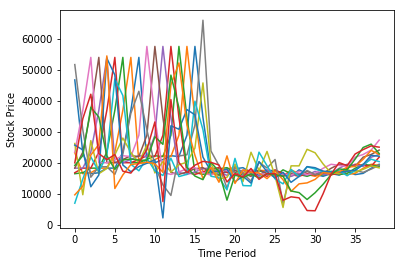

In [315]:
answer=LSTM(txs,7,'WeekNumber_Month_Season_Year' )

In [316]:
len(answer)

2

In [317]:
predict=answer[0]

In [318]:
real=answer[1]

In [322]:
predict

array([ 19292.24804688,  18450.27929688,  20468.671875  ,  22199.36523438,
        22779.8515625 ,  23070.11132812,  25120.765625  ], dtype=float32)

In [320]:
real[-1]

array([ 19616.21999997,  19251.49999997,  18947.80999997,  21904.46999996,
        22764.00999996,  24185.26999996,  27390.80999995])

In [323]:
rmse(predict,real[-1])

1167.6489055473505

In [ ]:
list(predict[-1])

In [325]:
forecastDay=7

In [326]:
[1,2,3]+[0]*forecastDay

[1, 2, 3, 0, 0, 0, 0, 0, 0, 0]

In [335]:
 list(np.log([1,2,3]))+list((np.log([1]*forecastDay)))

[0.0,
 0.69314718055994529,
 1.0986122886681098,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [332]:
np.log([1]*forecastDay)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [234]:
denormalizedTestPredictY=[item for sublist in predict for item in sublist]

In [235]:
denormalizedTestPredictY

[25004.889,
 17878.67,
 18448.551,
 16625.063,
 23794.762,
 18926.037,
 22310.779,
 28988.189,
 16647.063,
 17655.199,
 15902.258,
 18758.281,
 21422.873,
 18815.676,
 27390.082,
 42252.961,
 13023.616,
 -17054.637,
 8713.7109,
 44013.387,
 28824.037,
 54875.152,
 9814.6406,
 6892.9678,
 34119.309,
 32063.373,
 17950.139,
 17710.721,
 46269.297,
 34165.398,
 26859.049,
 31506.697,
 40626.762,
 33309.164,
 32144.885,
 10130.913,
 19886.119,
 25303.898,
 12353.382,
 17963.152,
 22309.063,
 19594.828,
 20738.941,
 36639.18,
 13155.897,
 17237.949,
 1872.4343,
 7594.7642,
 22348.809,
 28669.564,
 59840.152,
 63524.957,
 33534.887,
 35908.84,
 25697.67,
 28739.646,
 49920.723,
 37315.395,
 24844.428,
 22487.34,
 31232.457,
 10106.243,
 17534.168,
 19177.609,
 15914.949,
 18269.627,
 15585.958,
 14997.678,
 13669.889,
 16800.967,
 17152.875,
 16120.986,
 12658.109,
 16700.432,
 11799.587,
 -2452.4717,
 13090.211,
 13131.864,
 -8086.0894,
 -10138.832,
 20595.971,
 29082.613,
 58904.629,
 1427

In [236]:
denormalizedTestY=originalSales[train_size+seq_length:]

NameError: name 'originalSales' is not defined

In [ ]:
# sales=noOutlierSales(sales)
tempxy=[list(txs['season']),list(txs['year']),list(txs['month']),list(txs['week_number']),sales]
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]
xy=np.array(tempxy).transpose().astype(np.float)
originalxy=np.array(tempxy).transpose().astype(np.float)
xy=minMaxNormalizer(xy)

#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=len(tempxy)
#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5
#output_dim(=forecastDays)만큼의 다음날 y_data를 예측

output_dim=forecastDay
#hidden_dim은 정말 임의로 설정
hidden_dim=100
#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01
#iterations는 반복 횟수
iterations=1000
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length - forecastDay):
    _x=x[i:i+seq_length]
    _y = y[i + seq_length:i + seq_length + forecastDay]
    _y = np.reshape(_y, (forecastDay))
#     print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)
    train_size = int(len(dataY) * 0.7)
    
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDay])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
denormalizedTestY=originalSales[train_size+seq_length:]
# denormalizedTestY_original=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalxy)

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [ ]:
print(i for i in list(test_predict[-1]    ))

In [5]:
list(test_predict[  )

[17721.039]

In [6]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [7]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

IndexError: list index out of range

In [ ]:
len(denormalizedTestPredictY)

In [ ]:
denormalizedTestY